In [52]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor ,GradientBoostingRegressor,AdaBoostRegressor
from sklearn.svm import SVR,LinearSVR
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb
import lightgbm as lgb


%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [12]:
df=pd.read_csv("/content/UberDataset.csv")

In [13]:
df.head()

,START_DATE,END_DATE,CATEGORY,START,STOP,MILES,PURPOSE
0,01-01-2016 21:11,01-01-2016 21:17,Business,Fort Pierce,Fort Pierce,5.1,Meal/Entertain
1,01-02-2016 01:25,01-02-2016 01:37,Business,Fort Pierce,Fort Pierce,5.0,NaN
2,01-02-2016 20:25,01-02-2016 20:38,Business,Fort Pierce,Fort Pierce,4.8,Errand/Supplies
3,01-05-2016 17:31,01-05-2016 17:45,Business,Fort Pierce,Fort Pierce,4.7,Meeting
4,01-06-2016 14:42,01-06-2016 15:49,Business,Fort Pierce,West Palm Beach,63.7,Customer Visit


In [16]:
df.shape

(1156, 7)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1156 entries, 0 to 1155
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   START_DATE  1156 non-null   object 
 1   END_DATE    1155 non-null   object 
 2   CATEGORY    1155 non-null   object 
 3   START       1155 non-null   object 
 4   STOP        1155 non-null   object 
 5   MILES       1156 non-null   float64
 6   PURPOSE     653 non-null    object 
dtypes: float64(1), object(6)
memory usage: 63.3+ KB


In [17]:
df.describe()

,MILES
count,1156.000000
mean,21.115398
std,359.299007
min,0.500000
25%,2.900000
50%,6.000000
75%,10.400000
max,12204.700000


In [18]:
df[df.duplicated()]

,START_DATE,END_DATE,CATEGORY,START,STOP,MILES,PURPOSE
492,6/28/2016 23:34,6/28/2016 23:59,Business,Durham,Cary,9.9,Meeting


In [19]:
df.drop_duplicates(inplace = True)

In [20]:
df.isnull().sum()

START_DATE      0
END_DATE        1
CATEGORY        1
START           1
STOP            1
MILES           0
PURPOSE       503
dtype: int64

In [21]:
df["PURPOSE"] = df["PURPOSE"].fillna("Missing")
df.dropna(inplace = True)

In [22]:
df.isnull().sum()

START_DATE    0
END_DATE      0
CATEGORY      0
START         0
STOP          0
MILES         0
PURPOSE       0
dtype: int64

In [23]:
# Converting dtype as datetime
df['START_DATE'] = pd.to_datetime(df['START_DATE'])
df['END_DATE'] = pd.to_datetime(df['END_DATE'])


In [24]:
# Renameing of features
df.rename(columns={
    'START_DATE': 'start_date',
    'END_DATE': 'end_date',
    'CATEGORY': 'category',
    'START' : 'start',
    'STOP' : 'stop',
    'MILES' : 'miles',
    'PURPOSE' : 'purpose'
}, inplace=True)

In [25]:
# Creating new features for better analysis and accuracy

# df["year"] = df['start_date'].dt.year
df['day_name'] = df['start_date'].dt.day_name()

time_periods = [0, 6, 12, 18, 24]
labels = ['Night', 'Morning', 'Afternoon', 'Evening']

df['time_label'] = pd.cut(df['start_date'].dt.hour, bins=time_periods, labels=labels, right=False)

df["month"] = df['start_date'].dt.month_name()

df['duration'] = (df['end_date'] - df['start_date']).astype('timedelta64[m]')

In [26]:
data = df.copy()
df.head(5)

,start_date,end_date,category,start,stop,miles,purpose,day_name,time_label,month,duration
0,2016-01-01 21:11:00,2016-01-01 21:17:00,Business,Fort Pierce,Fort Pierce,5.1,Meal/Entertain,Friday,Evening,January,6.0
1,2016-01-02 01:25:00,2016-01-02 01:37:00,Business,Fort Pierce,Fort Pierce,5.0,Missing,Saturday,Night,January,12.0
2,2016-01-02 20:25:00,2016-01-02 20:38:00,Business,Fort Pierce,Fort Pierce,4.8,Errand/Supplies,Saturday,Evening,January,13.0
3,2016-01-05 17:31:00,2016-01-05 17:45:00,Business,Fort Pierce,Fort Pierce,4.7,Meeting,Tuesday,Afternoon,January,14.0
4,2016-01-06 14:42:00,2016-01-06 15:49:00,Business,Fort Pierce,West Palm Beach,63.7,Customer Visit,Wednesday,Afternoon,January,67.0


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 [Text(0, 0, 'Meal/Entertain'),
  Text(1, 0, 'Missing'),
  Text(2, 0, 'Errand/Supplies'),
  Text(3, 0, 'Meeting'),
  Text(4, 0, 'Customer Visit'),
  Text(5, 0, 'Temporary Site'),
  Text(6, 0, 'Between Offices'),
  Text(7, 0, 'Charity ($)'),
  Text(8, 0, 'Commute'),
  Text(9, 0, 'Moving'),
  Text(10, 0, 'Airport/Travel')])

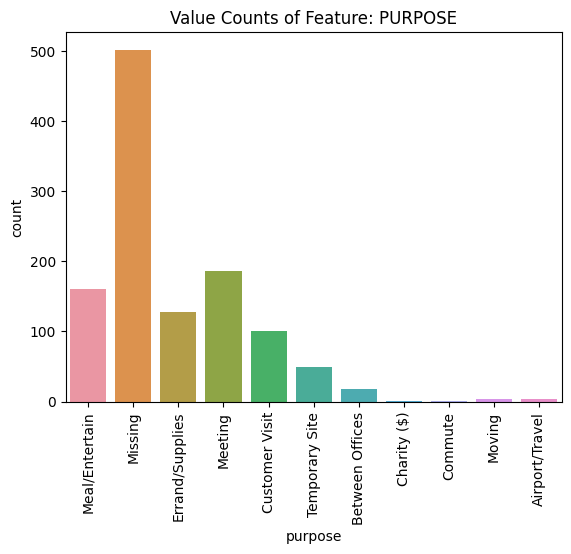

In [27]:
sns.countplot(x=df["purpose"])
plt.title("Value Counts of Feature: PURPOSE")
plt.xticks(rotation=90)

(array([0, 1]), [Text(0, 0, 'Business'), Text(1, 0, 'Personal')])

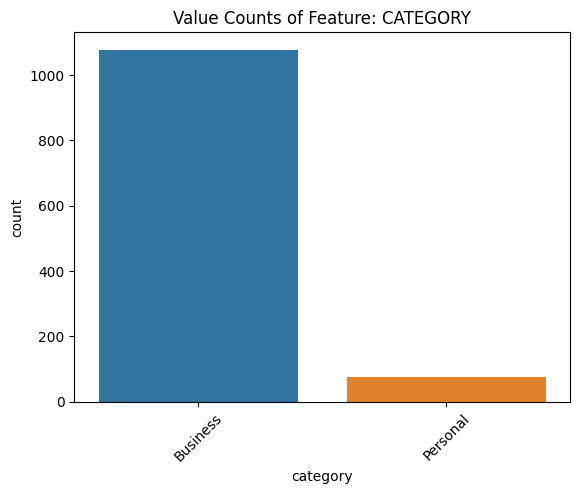

In [28]:
sns.countplot(x=df["category"])
plt.title("Value Counts of Feature: CATEGORY")
plt.xticks(rotation=45)

(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, 'Friday'),
  Text(1, 0, 'Saturday'),
  Text(2, 0, 'Tuesday'),
  Text(3, 0, 'Wednesday'),
  Text(4, 0, 'Thursday'),
  Text(5, 0, 'Sunday'),
  Text(6, 0, 'Monday')])

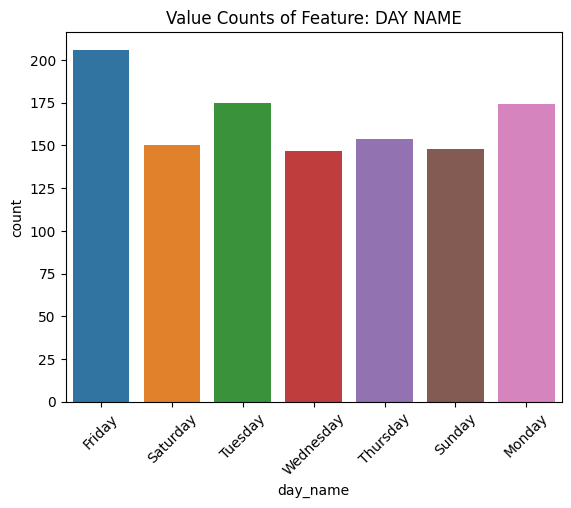

In [29]:
sns.countplot(x=df["day_name"])
plt.title("Value Counts of Feature: DAY NAME")
plt.xticks(rotation=45)

(array([0, 1, 2, 3]),
 [Text(0, 0, 'Night'),
  Text(1, 0, 'Morning'),
  Text(2, 0, 'Afternoon'),
  Text(3, 0, 'Evening')])

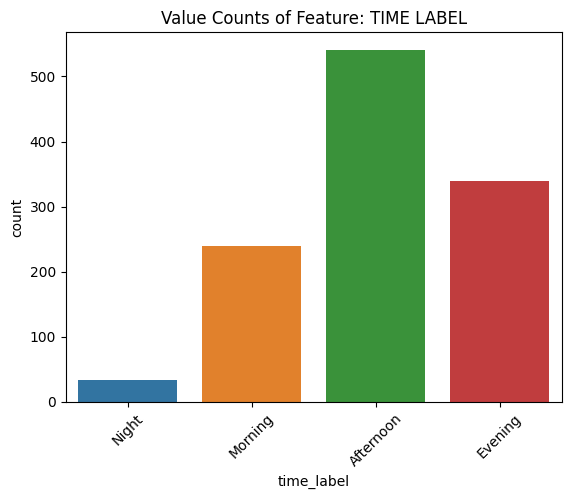

In [30]:
sns.countplot(x=df["time_label"])
plt.title("Value Counts of Feature: TIME LABEL")
plt.xticks(rotation=45)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 [Text(0, 0, 'January'),
  Text(1, 0, 'February'),
  Text(2, 0, 'March'),
  Text(3, 0, 'April'),
  Text(4, 0, 'May'),
  Text(5, 0, 'June'),
  Text(6, 0, 'July'),
  Text(7, 0, 'August'),
  Text(8, 0, 'September'),
  Text(9, 0, 'October'),
  Text(10, 0, 'November'),
  Text(11, 0, 'December')])

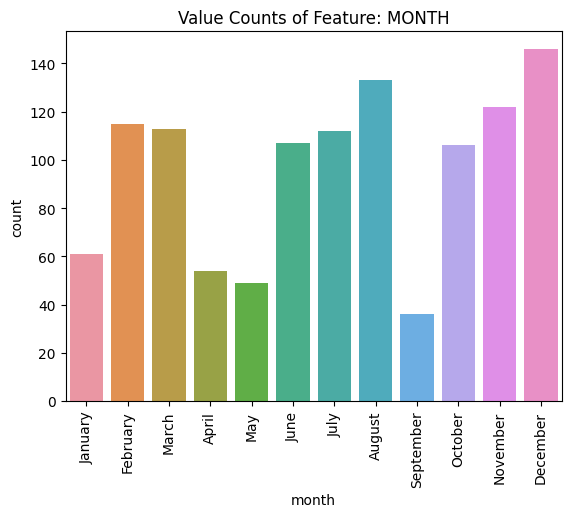

In [31]:
sns.countplot(x=df["month"])
plt.title("Value Counts of Feature: MONTH")
plt.xticks(rotation=90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 [Text(0, 0, 'Meal/Entertain'),
  Text(1, 0, 'Missing'),
  Text(2, 0, 'Errand/Supplies'),
  Text(3, 0, 'Meeting'),
  Text(4, 0, 'Customer Visit'),
  Text(5, 0, 'Temporary Site'),
  Text(6, 0, 'Between Offices'),
  Text(7, 0, 'Charity ($)'),
  Text(8, 0, 'Commute'),
  Text(9, 0, 'Moving'),
  Text(10, 0, 'Airport/Travel')])

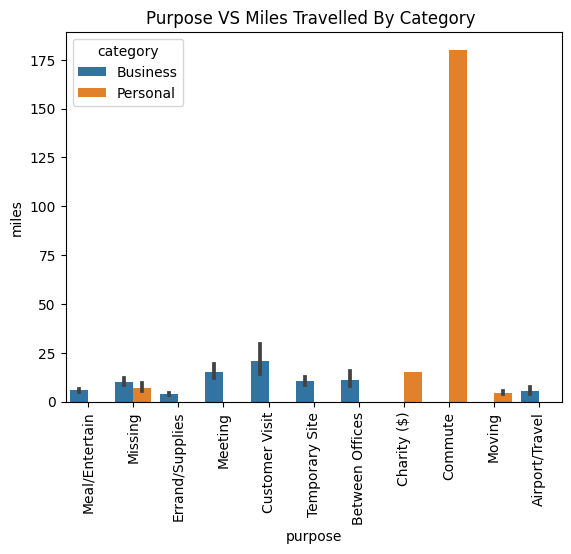

In [32]:
sns.barplot(x= df["purpose"], y= df['miles'],hue = df["category"])
plt.title("Purpose VS Miles Travelled By Category ")
plt.xticks(rotation=90)

Text(0.5, 1.0, 'Outliers in MILES over TIME')

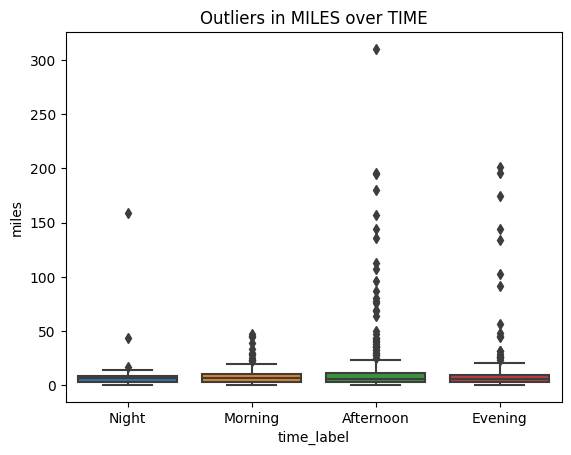

In [33]:
sns.boxplot(x=df["time_label"],y=df["miles"])
plt.title("Outliers in MILES over TIME")

Text(0.5, 1.0, 'Outliers in Duration')

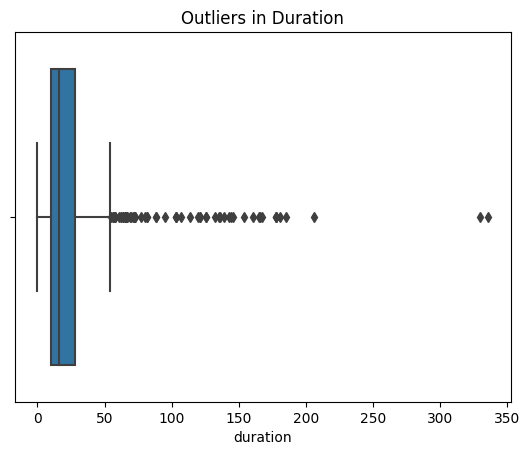

In [34]:
sns.boxplot(x=df["duration"],data=df)
plt.title("Outliers in Duration")

Text(0.5, 1.0, 'Outliers in Miles')

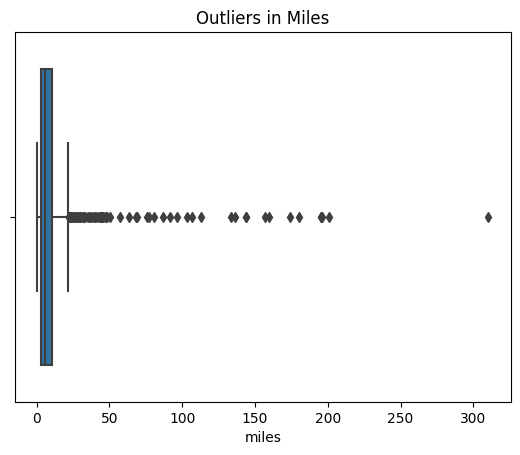

In [35]:
sns.boxplot(x=df['miles'],data = df)
plt.title("Outliers in Miles")

Text(0.5, 1.0, 'Density PLot for Miles')

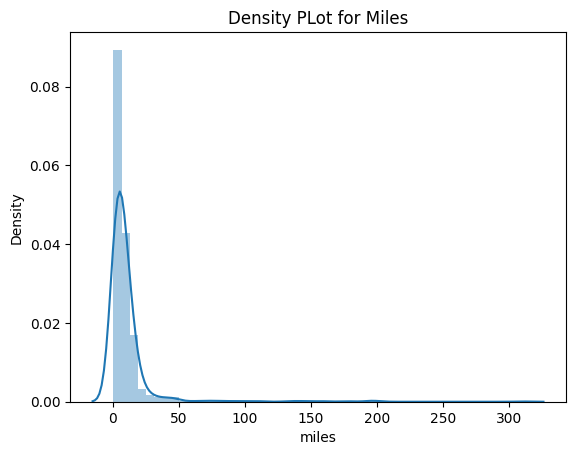

In [36]:
sns.distplot(df["miles"])
plt.title("Density PLot for Miles")

Text(0.5, 1.0, 'Density PLot for Duration')

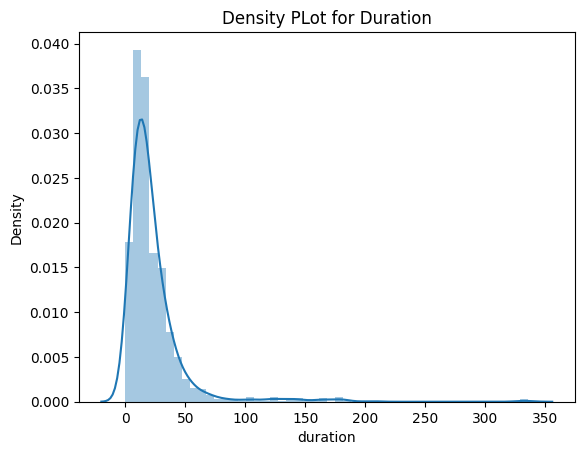

In [37]:

sns.distplot(df["duration"])
plt.title("Density PLot for Duration")

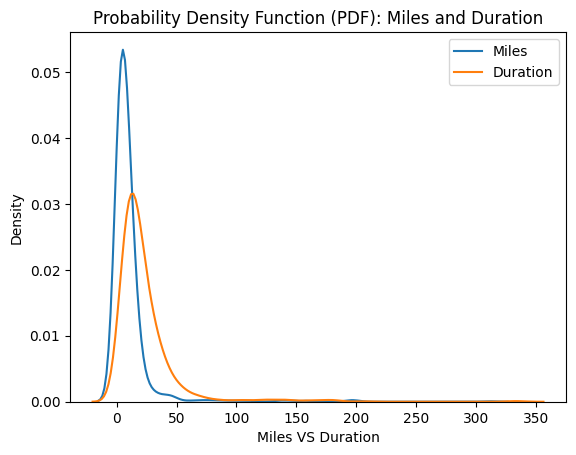

In [38]:
sns.distplot(df["miles"],hist = False,label="Miles")
sns.distplot(df["duration"],hist = False, label="Duration")
plt.title("Probability Density Function (PDF): Miles and Duration")
plt.xlabel("Miles VS Duration")
plt.legend()

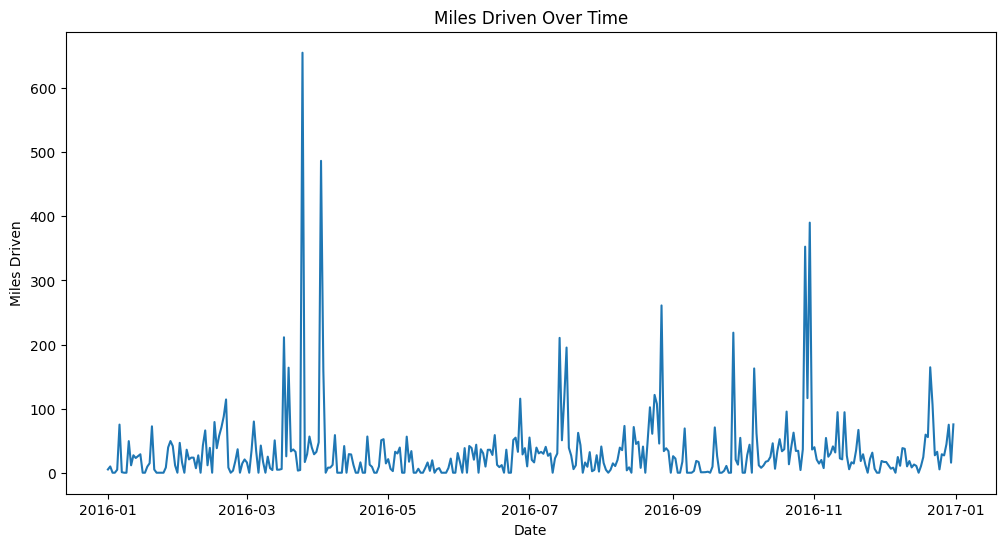

In [39]:
df = df[df['start_date'] != "Totals"]
df['start_date'] = pd.to_datetime(df['start_date'])
df.set_index('start_date', inplace=True)
daily_miles = df.resample('D')['miles'].sum()
plt.figure(figsize=(12, 6))
plt.plot(daily_miles.index, daily_miles.values)
plt.xlabel('Date')
plt.ylabel('Miles Driven')
plt.title('Miles Driven Over Time')
plt.show()

In [40]:
# Calculate IQR for 'miles' feature
Q1_miles = np.percentile(df['miles'], 25)
Q3_miles = np.percentile(df['miles'], 75)
IQR_miles = Q3_miles - Q1_miles

# Calculate IQR for 'duration' feature
Q1_duration = np.percentile(df['duration'], 25)
Q3_duration = np.percentile(df['duration'], 75)
IQR_duration = Q3_duration - Q1_duration

# Define outlier boundaries
lower_bound_miles = Q1_miles - 1.5 * IQR_miles
upper_bound_miles = Q3_miles + 1.5 * IQR_miles

lower_bound_duration = Q1_duration - 1.5 * IQR_duration
upper_bound_duration = Q3_duration + 1.5 * IQR_duration

# Identify and deal with outliers
df['miles'] = np.where(df['miles'] < lower_bound_miles, lower_bound_miles, df['miles'])
df['miles'] = np.where(df['miles'] > upper_bound_miles, upper_bound_miles, df['miles'])

df['duration'] = np.where(df['duration'] < lower_bound_duration, lower_bound_duration, df['duration'])
df['duration'] = np.where(df['duration'] > upper_bound_duration, upper_bound_duration, df['duration'])

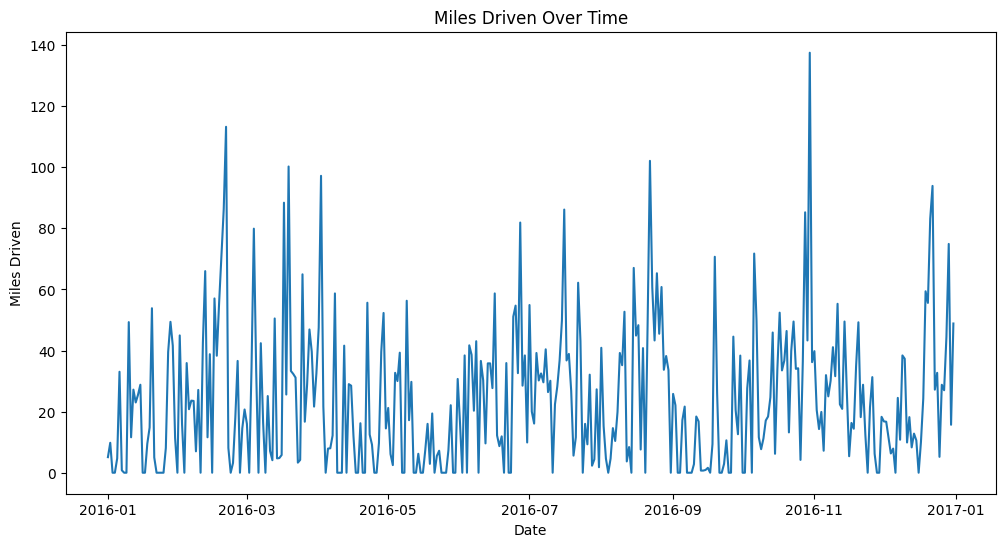

In [41]:
daily_miles = df.resample('D')['miles'].sum()
plt.figure(figsize=(12, 6))
plt.plot(daily_miles.index, daily_miles.values)
plt.xlabel('Date')
plt.ylabel('Miles Driven')
plt.title('Miles Driven Over Time')
plt.show()

In [42]:
# Using pandas to encode featuers
df_encoded = pd.get_dummies(data, columns=['category', 'start',"purpose", 'stop', 'day_name', 'time_label', 'month'])

In [43]:
# Spliting Data into Train and Test
from sklearn.model_selection import train_test_split
X = df_encoded.drop(['miles',"start_date","end_date"], axis=1)
y = df_encoded['miles']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [46]:
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(),
    'SVR': SVR(),
    'XGBoost': xgb.XGBRegressor(),
    'LightGBM': lgb.LGBMRegressor(),
    'Gradient Boosting Regressor' : GradientBoostingRegressor(),
    'ADA Boost' : AdaBoostRegressor(),
    'Linear SVR' : LinearSVR(),
    'KNN Regressor' : KNeighborsRegressor()
}

In [47]:
accuracy = {}
predictions = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    predictions[name] = y_pred

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002271 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 162
[LightGBM] [Info] Number of data points in the train set: 923, number of used features: 50
[LightGBM] [Info] Start training from score 10.210943


Results for Linear Regression:
Mean Squared Error: 7.211514271549394e+19
R-squared Score: -9.968810752652533e+16


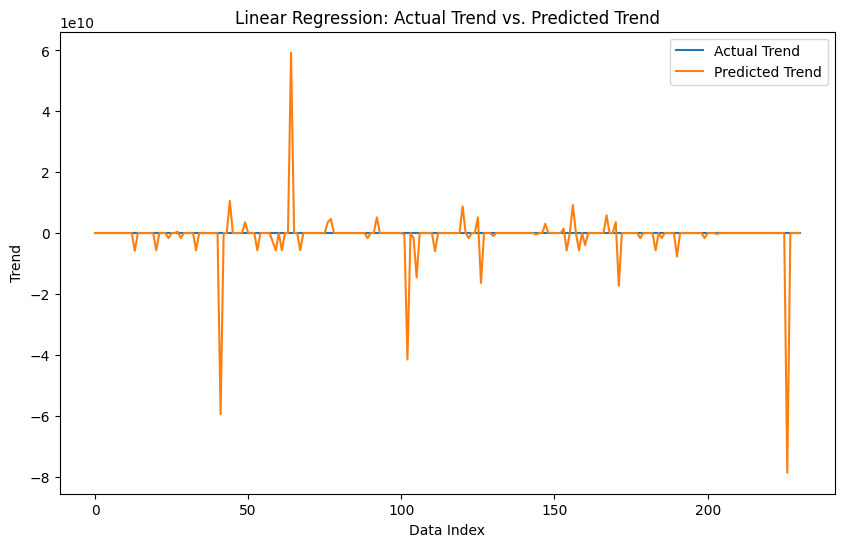


Results for Decision Tree:
Mean Squared Error: 159.51130952380953
R-squared Score: 0.7795001163869294


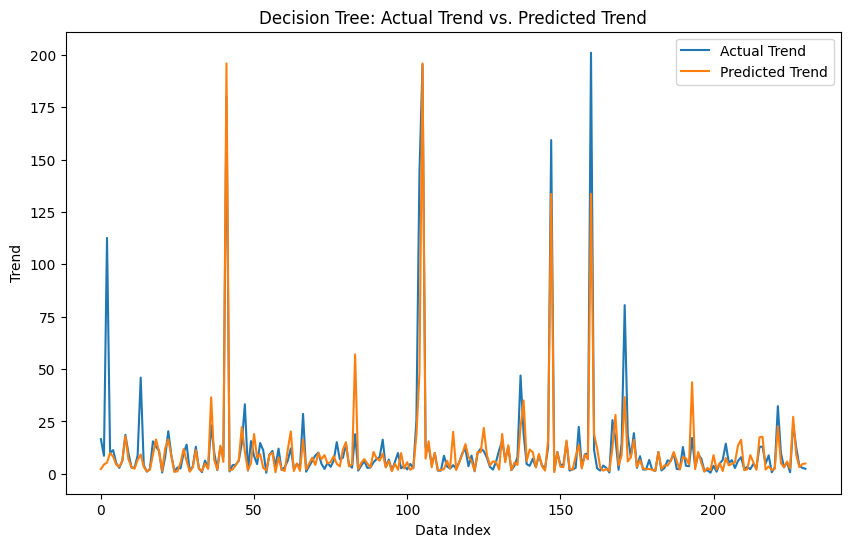


Results for Random Forest:
Mean Squared Error: 200.85109780489472
R-squared Score: 0.7223542091043638


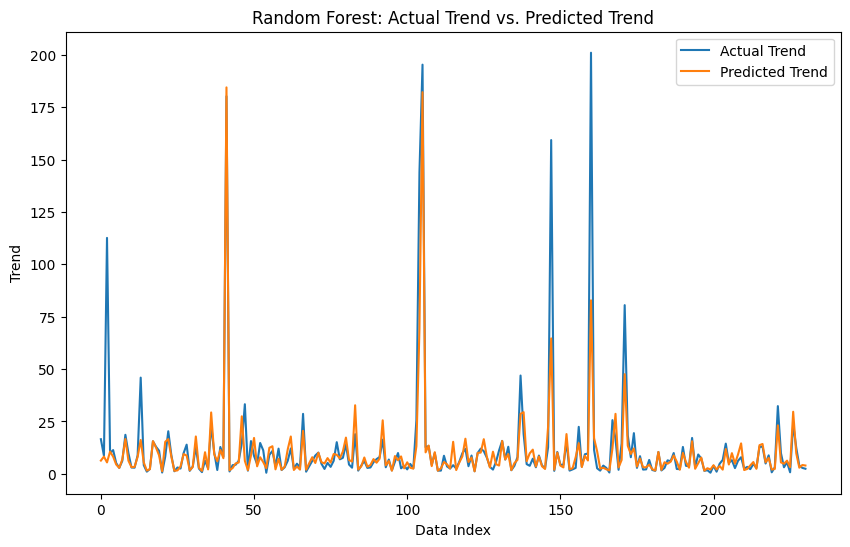


Results for SVR:
Mean Squared Error: 606.9156550605561
R-squared Score: 0.16103233242011794


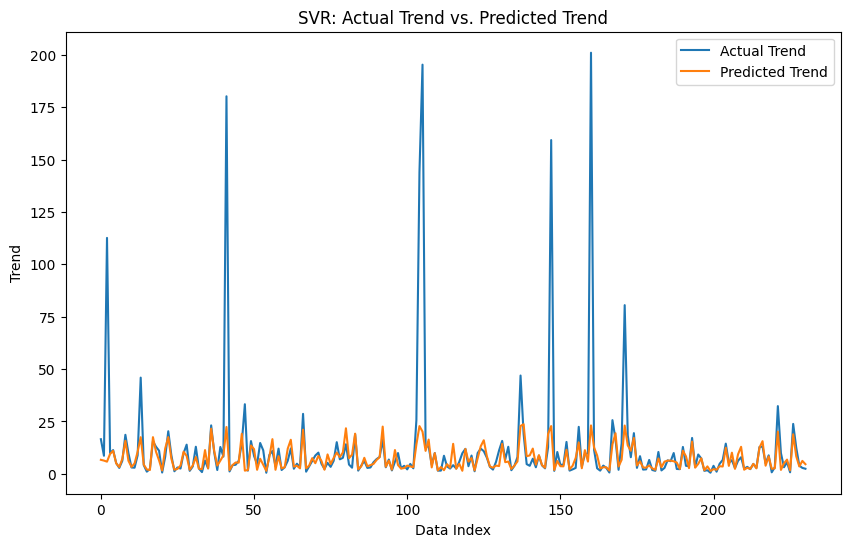


Results for XGBoost:
Mean Squared Error: 129.3486236917802
R-squared Score: 0.8211953963973248


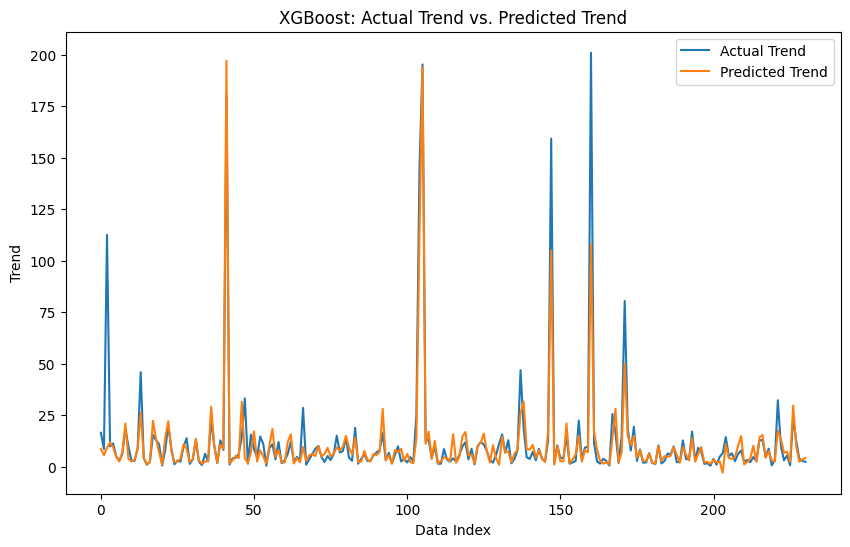


Results for LightGBM:
Mean Squared Error: 176.7523595912864
R-squared Score: 0.7556670129875851


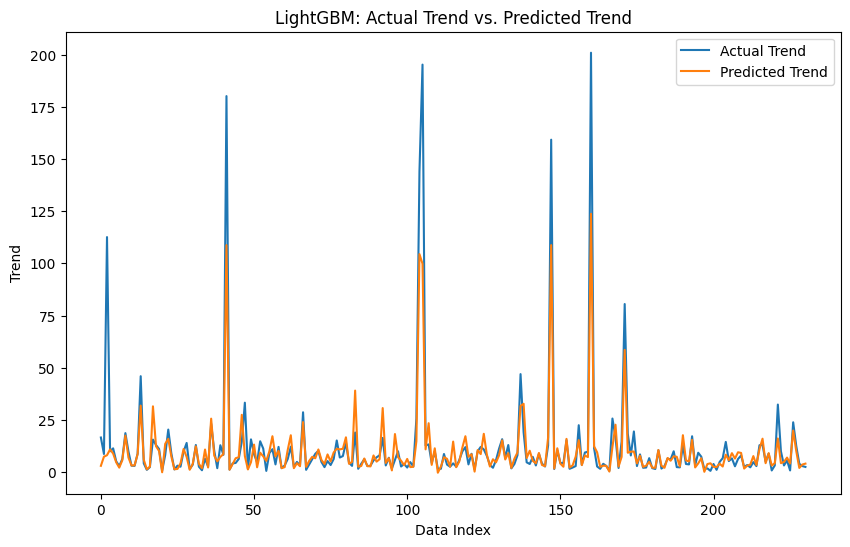


Results for Gradient Boosting Regressor:
Mean Squared Error: 194.37383742525702
R-squared Score: 0.7313080266368346


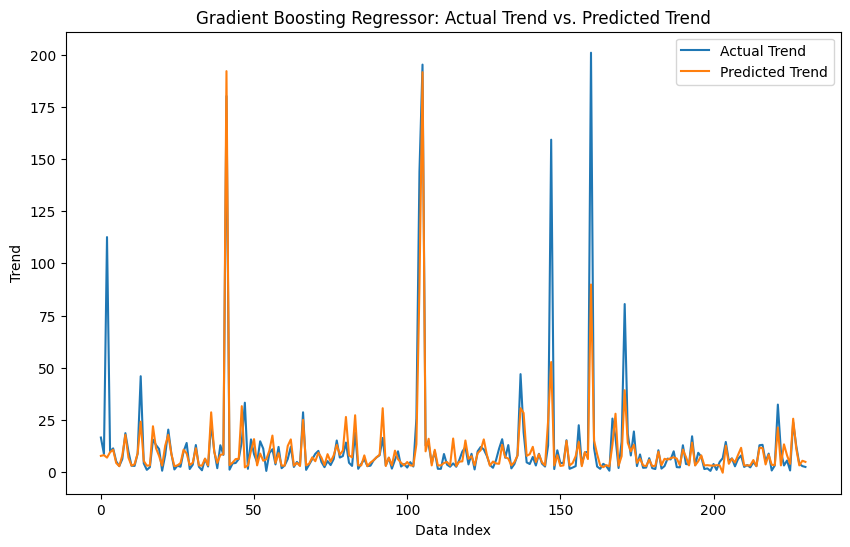


Results for ADA Boost:
Mean Squared Error: 191.82702549214878
R-squared Score: 0.7348286029302097


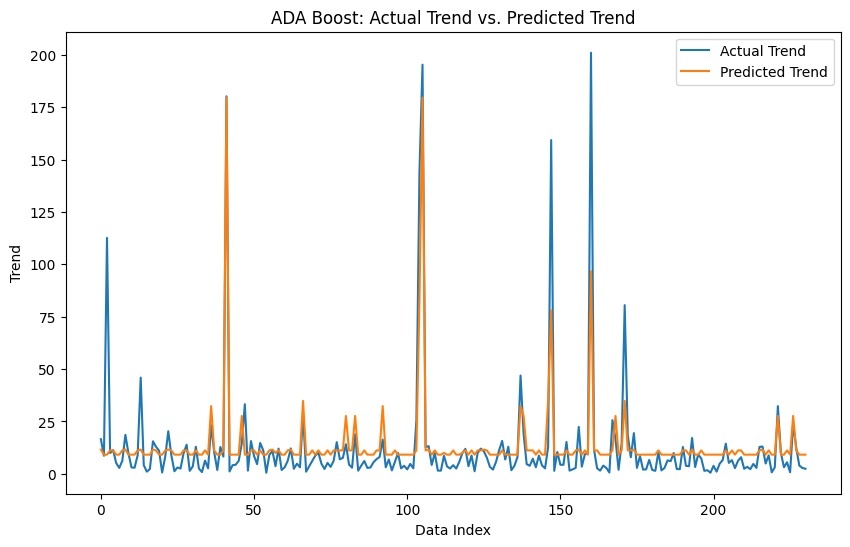


Results for Linear SVR:
Mean Squared Error: 347.2115522319988
R-squared Score: 0.5200333626197111


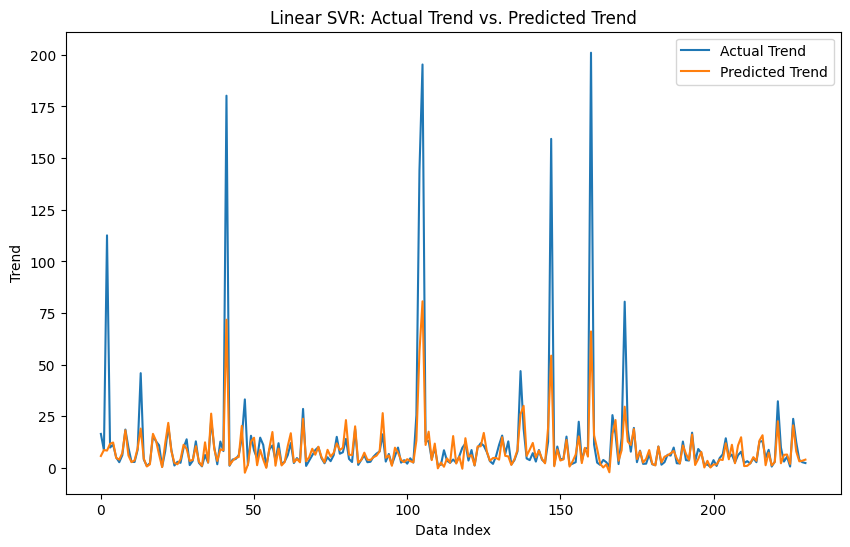


Results for KNN Regressor:
Mean Squared Error: 240.3059913419914
R-squared Score: 0.6678138792752908


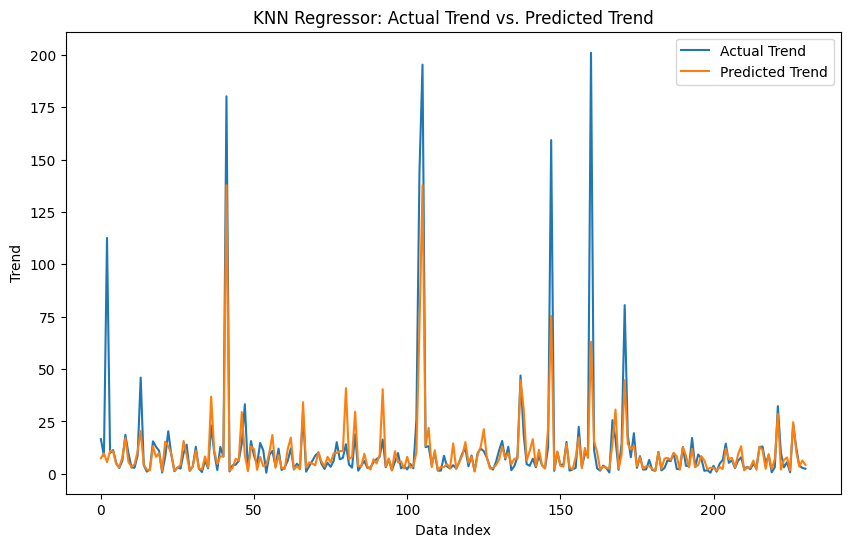

In [48]:
for name, y_pred in predictions.items():
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    accuracy[name] = r2

    print(f"Results for {name}:")
    print(f"Mean Squared Error: {mse}")
    print(f"R-squared Score: {r2}")

    plt.figure(figsize=(10, 6))
    plt.plot(np.arange(len(y_test)), y_test, label='Actual Trend')
    plt.plot(np.arange(len(y_test)), y_pred, label='Predicted Trend')
    plt.xlabel('Data Index')
    plt.ylabel('Trend')
    plt.title(f'{name}: Actual Trend vs. Predicted Trend')
    plt.legend()
    plt.show()
    print()

In [51]:
accuracy_df = pd.DataFrame(dict(Model=list(accuracy.keys()), Accuracy_Score=list(accuracy.values())))
accuracy_df

,Model,Accuracy_Score
0,Linear Regression,-9.968811e+16
1,Decision Tree,7.795001e-01
2,Random Forest,7.223542e-01
3,SVR,1.610323e-01
4,XGBoost,8.211954e-01
5,LightGBM,7.556670e-01
6,Gradient Boosting Regressor,7.313080e-01
7,ADA Boost,7.348286e-01
8,Linear SVR,5.200334e-01
9,KNN Regressor,6.678139e-01
